In [129]:
# Dependancies 

import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2_contingency, mannwhitneyu
import umap

In [130]:
# DNA analysis class

class dna_mutation_class:
    
    """
    A class to analyze co-occurring mutations with EGFR in cancer patient DNA samples.
    """

    def __init__(self, metadata: pd.DataFrame, dna_mutations: pd.DataFrame) -> pd.DataFrame:
        """
        Initialize the EGFR mutation analysis object.

        Parameters:
        - metadata: DataFrame with EGFR-positive sample info. Must contain 'Sample_ID'.
        - dna_mutations: DataFrame with all DNA mutations. Must contain columns:
            'Sample_ID', 'gene', 'dna_vaf', etc.
        """
    
        self.metadata = metadata
        self.dna_mutations = dna_mutations
        self.egfr_samples = set(metadata["Sample_ID"].unique())
        self.results = pd.DataFrame()

    def compute_stats(self):
        
        """
        Computes co-occurrence statistics for each gene:
        - Chi-square test: presence/absence in EGFR+ vs EGFR− samples.
        - Mann–Whitney U test: distribution of 'dna_vaf' in EGFR+ vs EGFR− samples.
        Stores results in self.results DataFrame.
        """
        
        all_samples = set(self.dna_mutations["Sample_ID"].unique())
        egfr_positive = self.egfr_samples
        egfr_negative = all_samples - egfr_positive

        results = []

        all_genes = self.dna_mutations["gene"].unique()
        for gene in all_genes:
            if gene == "EGFR":
                continue  # Skip EGFR itself

            gene_data = self.dna_mutations[self.dna_mutations["gene"] == gene]

            gene_samples = set(gene_data["Sample_ID"])
            egfr_pos_with_gene = len(gene_samples & egfr_positive)
            egfr_pos_without_gene = len(egfr_positive) - egfr_pos_with_gene
            egfr_neg_with_gene = len(gene_samples & egfr_negative)
            egfr_neg_without_gene = len(egfr_negative) - egfr_neg_with_gene

            # Build 2x2 contingency table
            table = [
                [egfr_pos_with_gene, egfr_pos_without_gene],
                [egfr_neg_with_gene, egfr_neg_without_gene]
            ]
            chi2, chi2_p, _, _ = chi2_contingency(table)

            # MWU test (based on VAF values in gene_data)
            vaf_egfr_pos = gene_data[gene_data["Sample_ID"].isin(egfr_positive)]["dna_vaf"]
            vaf_egfr_neg = gene_data[gene_data["Sample_ID"].isin(egfr_negative)]["dna_vaf"]
            if len(vaf_egfr_pos) > 0 and len(vaf_egfr_neg) > 0:
                mwu_stat, mwu_p = mannwhitneyu(vaf_egfr_pos, vaf_egfr_neg, alternative="two-sided")
            else:
                mwu_p = 1.0  # Non-informative

            results.append({
                "gene": gene,
                "chi2_p": chi2_p,
                "chi2_neglogp": -np.log10(chi2_p) if chi2_p > 0 else np.nan,
                "mwu_p": mwu_p,
                "mwu_neglogp": -np.log10(mwu_p) if mwu_p > 0 else np.nan,
                "EGFR+_with_gene": egfr_pos_with_gene,
                "EGFR-_with_gene": egfr_neg_with_gene
            })

        self.results = pd.DataFrame(results).dropna()

    def plot_bar_charts(self, top_n=20):

        """
        Plot top co-occurring genes ranked by -log10(p-value) for each test.

        Args:
            top_n (int): Number of top genes to display.
        """
        
        df_chi = self.results.sort_values("chi2_neglogp", ascending=False).head(top_n)
        plt.figure(figsize=(12, 6))
        sns.barplot(x="chi2_neglogp", y="gene", data=df_chi, palette="viridis")
        plt.xlabel("-log10(p-value) [Chi-square]")
        plt.ylabel("Gene")
        plt.title(f"Top {top_n} Co-occurring Genes with EGFR (Chi-square)")
        plt.tight_layout()
        plt.show()

        df_mwu = self.results.sort_values("mwu_neglogp", ascending=False).head(top_n)
        plt.figure(figsize=(12, 6))
        sns.barplot(x="mwu_neglogp", y="gene", data=df_mwu, palette="magma")
        plt.xlabel("-log10(p-value) [Mann–Whitney U]")
        plt.ylabel("Gene")
        plt.title(f"Top {top_n} Co-occurring Genes with EGFR (MWU)")
        plt.tight_layout()
        plt.show()

    def plot_scatter(self):

        """
        Scatter plot comparing -log10(p-values) from Chi-square vs MWU tests.
        """

        # ## Colour by significance in both tests
        # self.results["significant"] = (
        # (self.results["chi2_p"] < 0.05) & (self.results["mwu_p"] < 0.05)
        # )

        
        # plt.figure(figsize=(8, 6))
        # sns.scatterplot(
        #     data=self.results,
        #     x="chi2_neglogp", y="mwu_neglogp",
        #     hue="gene", legend=False
        # )

        sns.scatterplot(
            data=self.results,
            x="chi2_neglogp", y="mwu_neglogp",
            hue="EGFR+_with_gene", palette="viridis"
        )

        plt.xlabel("-log10(p-value) Chi-square")
        plt.ylabel("-log10(p-value) MWU")
        plt.title("Chi-square vs MWU: Co-occurring Gene Significance")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [131]:
# Load in data

dna_meta = pd.read_csv("data/detailed_egfr_meta.csv")

dna_mutations = pd.read_csv("data/TCGA-LUAD.mutect2_snv.tsv", sep='\t')



In [132]:
## View meta

dna_meta


,Unnamed: 0,Sample_ID,gene,Amino_Acid_Change
0,4673,TCGA-MP-A4SW-01A,EGFR,L858R
1,6231,TCGA-97-8547-01A,EGFR,E746_A750del
2,7672,TCGA-71-8520-01A,EGFR,L62R
3,7673,TCGA-71-8520-01A,EGFR,L858R
4,11243,TCGA-86-8074-01A,EGFR,E746_A750del
...,...,...,...,...
78,201059,TCGA-38-4627-01A,EGFR,L62R
79,201060,TCGA-38-4627-01A,EGFR,L858R
80,201134,TCGA-17-Z032-01A,EGFR,E746_A750del
81,202032,TCGA-67-3772-01A,EGFR,L858R


In [133]:
# View mutations data

dna_mutations


,Sample_ID,gene,chrom,start,end,ref,alt,Amino_Acid_Change,effect,filter,dna_vaf
0,TCGA-97-7938-01A,PTCHD2,chr1,11517599,11517599,C,A,p.T629N,missense_variant,PASS,0.368421
1,TCGA-97-7938-01A,HNRNPCL1,chr1,12847895,12847895,G,T,p.P132H,missense_variant,PASS,0.381579
2,TCGA-97-7938-01A,PADI1,chr1,17230152,17230152,A,G,p.N333D,missense_variant,PASS,0.191011
3,TCGA-97-7938-01A,SH2D5,chr1,20727574,20727574,C,G,p.L39L,synonymous_variant,PASS,0.315789
4,TCGA-97-7938-01A,ARID1A,chr1,26771167,26771167,G,T,p.G1083C,missense_variant,PASS,0.348837
...,...,...,...,...,...,...,...,...,...,...,...
208175,TCGA-78-7537-01A,RBM10,chrX,47173183,47173183,G,-,p.N164Tfs*102,frameshift_variant,PASS,0.708333
208176,TCGA-78-7537-01A,PHF8,chrX,54014452,54014452,G,A,p.L272L,synonymous_variant,PASS,0.700000
208177,TCGA-78-7537-01A,ZCCHC5,chrX,78657430,78657430,G,A,p.Q331*,stop_gained,PASS,0.818182
208178,TCGA-78-7537-01A,ZBTB33,chrX,120253552,120253552,A,T,p.H46L,missense_variant,PASS,0.663317


In [134]:
# dna meta fixing

## Remove unnamed column
dna_meta = dna_meta.drop(["Unnamed: 0"], axis = 1)

# ## setsubmitter_id_samples as the index
# dna_meta.set_index('Sample_ID', inplace=True)

## View dna meta
dna_meta

,Sample_ID,gene,Amino_Acid_Change
0,TCGA-MP-A4SW-01A,EGFR,L858R
1,TCGA-97-8547-01A,EGFR,E746_A750del
2,TCGA-71-8520-01A,EGFR,L62R
3,TCGA-71-8520-01A,EGFR,L858R
4,TCGA-86-8074-01A,EGFR,E746_A750del
...,...,...,...
78,TCGA-38-4627-01A,EGFR,L62R
79,TCGA-38-4627-01A,EGFR,L858R
80,TCGA-17-Z032-01A,EGFR,E746_A750del
81,TCGA-67-3772-01A,EGFR,L858R


In [135]:
# Analyse mutations data

analyzer = dna_mutation_class(dna_meta, dna_mutations)

analyzer.compute_stats()


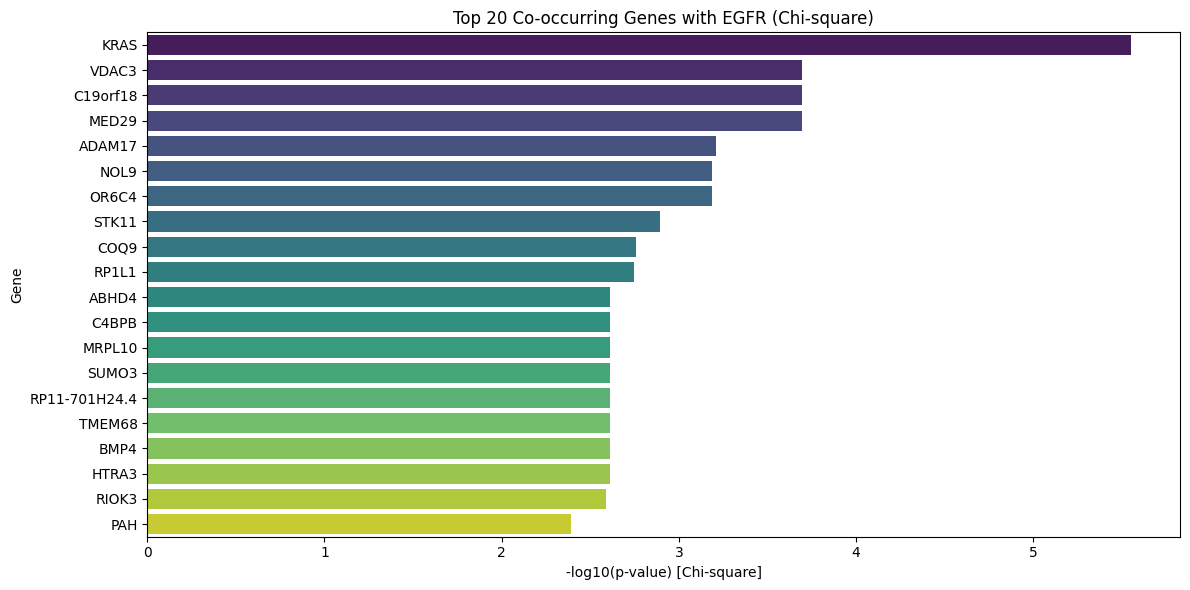

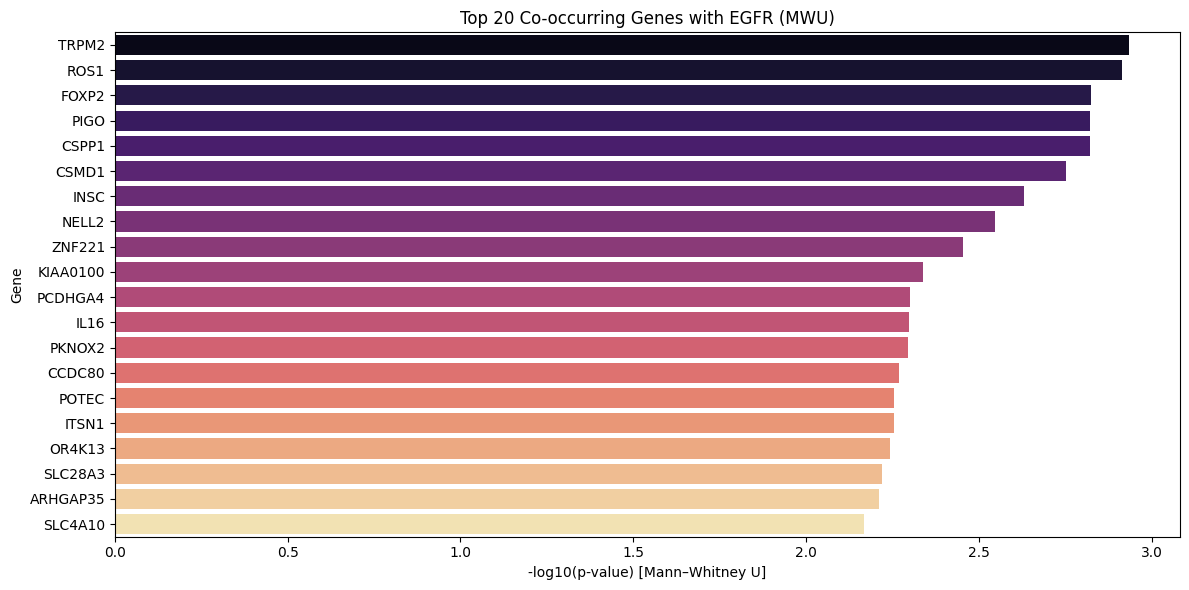

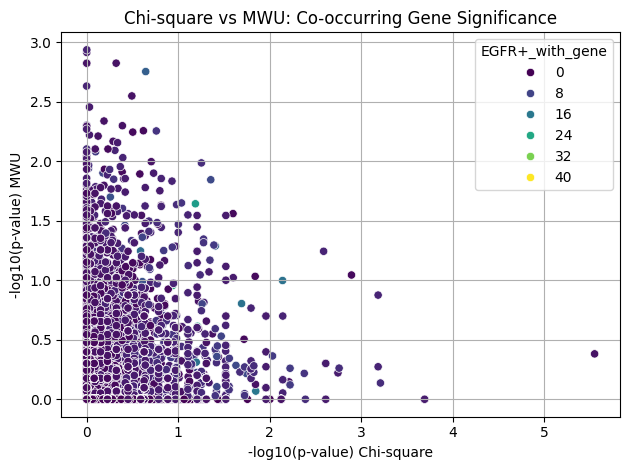

In [136]:
# Create plots

analyzer.plot_bar_charts()
analyzer.plot_scatter()